# Data Science and Artificial Intelligence Certificate <a class="jp-toc-ignore"></a>
## Machine Learning Course: Final Group Project

---

**Professor:** Sebastian Maurice  
**Group Members:**
* Abdul Hujjati  
* Kavya Sidramappa Jadramakunti  
* S M Mozahidul Haque

## Table of Contents
1. [Data Collection and Cleanup](#1.)  
&nbsp;&nbsp;1.1 [Adding Indicators: Calculated from USD/CAD OHLCV](#1.1)  
&nbsp;&nbsp;1.2 [Downloading Data Correlated to USD/CAD Pair](#1.1.1)  
&nbsp;&nbsp;1.3 [Merging USD/CAD Bold Yield, WTI, IDX to Main df](#1.1.2)  
&nbsp;&nbsp;1.4 [Removing Nulls](#1.1.3)  
&nbsp;&nbsp;1.5 [Recomputing WTI and UDX returns after merge](#1.1.4)  
&nbsp;&nbsp;1.6 [Final Dataset](#1.1.5)  
2. [Machine Learning](#2.)  
&nbsp;&nbsp;2.1 [Configuration](#2.1)  
&nbsp;&nbsp;2.2 [XGBoost models with parameter grid search (Two Stage)](#2.2)  
&nbsp;&nbsp;&nbsp;&nbsp;2.2.1 [XGBoost - Stage 1 (Trade Filtering)](#2.2.1)  
&nbsp;&nbsp;&nbsp;&nbsp;2.2.2 [XGBoost - Stage 2 (Trade Direction Prediction)](#2.2.2)  
&nbsp;&nbsp;2.3 [Neural Network Two-Stage Models (Sequence)](#2.3)  
&nbsp;&nbsp;&nbsp;&nbsp;2.3.1 [Neural Network - Stage 1 (Trade Filtering)](#2.3.1)  
&nbsp;&nbsp;&nbsp;&nbsp;2.3.2 [Neural Network - Stage 2 (Trade Direction Prediction)](#2.3.2)  
&nbsp;&nbsp;2.4 [Leakage checks](#2.4)  
&nbsp;&nbsp;&nbsp;&nbsp;2.4.1[Shuffle Test](#2.4.1)  
&nbsp;&nbsp;&nbsp;&nbsp;2.4.2[Shifting Features Forward](#2.4.2)  
&nbsp;&nbsp;&nbsp;&nbsp;2.4.3[Single Label Scan](#2.4.3)

# <a id="1."></a>1. Data Collection and Cleanup

In [5]:
from datetime import datetime
import pandas as pd
import numpy as np
import dukascopy_python
from dukascopy_python.instruments import INSTRUMENT_FX_MAJORS_USD_CAD 
import pandas_ta as ta
import matplotlib.pyplot as plt
import dukascopy_python

In [6]:
# Reading previously downloaded dataset
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
df = pd.read_csv('USD_CAD_2012_2025.csv')

In [7]:
df.shape

(370390, 6)

In [8]:
# sorting by index
# Parse timestamp, set as index, then sort to guarantee time order for rolling features
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True, errors="coerce")
    df = df.dropna(subset=["timestamp"]).set_index("timestamp")
elif not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index, utc=True, errors="coerce")

# Ensuring UTC tz-aware DateTimeIndex
if isinstance(df.index, pd.DatetimeIndex):
    if df.index.tz is None:
        df.index = df.index.tz_localize("UTC")
    else:
        df.index = df.index.tz_convert("UTC")

df = df.sort_index()


In [9]:
df.head()

,open,high,low,close,volume
timestamp,,,,,
2012-01-11 01:30:00+00:00,1.01794,1.01836,1.01794,1.01803,536.52
2012-01-11 01:45:00+00:00,1.01798,1.01798,1.01755,1.01789,763.57
2012-01-11 02:00:00+00:00,1.01789,1.01797,1.01742,1.01766,920.21
2012-01-11 02:15:00+00:00,1.01767,1.01794,1.01763,1.01780,739.82
2012-01-11 02:30:00+00:00,1.01780,1.01826,1.01780,1.01799,912.26


## <a id="1.1"></a>1.1 Adding Indicators: Calculated from USD/CAD OHLCV

In [10]:
# Adding indicators:
# EMA for Trend, RSI-14, ATR 14, ADX, Bollinger Bands 

# Trend: EMA 50/200, distance, and crossover status
df['EMA_50'] = ta.ema(df['close'], length=50)
df['EMA_200'] = ta.ema(df['close'], length=200)
df['dist_ema_200'] = (df['close'] - df['EMA_200']) / df['EMA_200']  # Normalized distance
df['ema_crossover'] = (df['EMA_50'] > df['EMA_200']).astype(int)  # 1 if 50 > 200

# Momentum: RSI 14, overbought/oversold flags, and slope (velocity over 3 periods)
df['RSI'] = ta.rsi(df['close'], length=14)
df['RSI_overbought'] = (df['RSI'] > 70).astype(int)
df['RSI_oversold'] = (df['RSI'] < 30).astype(int)
df['RSI_velocity'] = df['RSI'].diff(3)

# Volatility: ATR 14, normalized
df['ATR'] = ta.atr(df['high'], df['low'], df['close'], length=14)
df['volatility'] = df['ATR'] / df['close']

# Strength: ADX 14, trending/ranging flags
df['ADX'] = ta.adx(df['high'], df['low'], df['close'], length=14)['ADX_14']
df['trending'] = (df['ADX'] > 25).astype(int)
df['ranging'] = (df['ADX'] < 20).astype(int)

# Mean Reversion: Bollinger Bands (20-period, 2 std), Percent B
bb = ta.bbands(df['close'], length=20, std=2)
df['BB_lower']  = bb['BBL_20_2.0_2.0']
df['BB_middle'] = bb['BBM_20_2.0_2.0']
df['BB_upper']  = bb['BBU_20_2.0_2.0']
df['percent_b'] = (df['close'] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'])  # 0-1 scale

In [11]:
# Ensure UTC DateTimeIndex (safe to rerun)
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True, errors="coerce")
    df = df.dropna(subset=["timestamp"]).set_index("timestamp")

if df.index.tz is None:
    df.index = df.index.tz_localize("UTC")
else:
    df.index = df.index.tz_convert("UTC")

df = df.sort_index()


In [13]:
# Hour & day features (UTC)
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek  # 0 = Monday

In [14]:
# Trading Session Dummies (DST-aware)
if df.index.tz is None:
    df.index = df.index.tz_localize("UTC")
else:
    df.index = df.index.tz_convert("UTC")

london = df.index.tz_convert("Europe/London")
newyork = df.index.tz_convert("America/New_York")

# London session: 08:00–16:00 London local time
df["london_session"] = ((london.hour >= 8) & (london.hour < 16)).astype(int)

# New York session: 08:00–16:00 New York local time
df["ny_session"] = ((newyork.hour >= 8) & (newyork.hour < 16)).astype(int)

# Overlap: when both sessions are open
df["overlap_session"] = (df["london_session"].astype(bool) & df["ny_session"].astype(bool)).astype(int)


In [15]:
# Cyclical Time Encoding
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

In [16]:
# Log Returns & Lagged Features
df['log_return'] = np.log(df['close'] / df['close'].shift(1))

# Lagged features
for lag in [1, 3, 5]:
    df[f'log_return_lag{lag}'] = df['log_return'].shift(lag)
    
    # Use RSI if it exists, otherwise RSI_velocity
    if 'RSI' in df.columns:
        df[f'RSI_lag{lag}'] = df['RSI'].shift(lag)
    else:
        df[f'RSI_velocity_lag{lag}'] = df['RSI_velocity'].shift(lag)

In [17]:
# Hurst / Fractal Dimension
def hurst_exponent(ts, max_lag=20):
    lags = range(2, max_lag)
    tau = [
        np.std(ts[lag:] - ts[:-lag])
        for lag in lags
        if len(ts) > lag
    ]

    if len(tau) < 2:
        return np.nan

    poly = np.polyfit(np.log(lags[:len(tau)]), np.log(tau), 1)
    return poly[0]

In [18]:
# Fractal dimension (rolling)
df['fractal_dim'] = df['close'].rolling(100).apply(
    lambda x: 1 + hurst_exponent(x.values),
    raw=False
)

In [19]:
df.shape

(370390, 37)

In [20]:
# Augmenting with Higher Timeframe indicators

# 1-HOUR FEATURES
df_1h = df.resample('1H').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
})

# Indicators on 1H
df_1h['EMA_200_1H'] = ta.ema(df_1h['close'], length=200)
df_1h['RSI_1H'] = ta.rsi(df_1h['close'], length=14)
df_1h['ATR_1H'] = ta.atr(df_1h['high'], df_1h['low'], df_1h['close'], length=14)
df_1h['ADX_1H'] = ta.adx(
    df_1h['high'], df_1h['low'], df_1h['close'], length=14
)['ADX_14']

# 🚨 Shift by 1 full 1H bar (CRITICAL to avoid look-ahead)
df_1h[['EMA_200_1H', 'RSI_1H', 'ATR_1H', 'ADX_1H']] = (
    df_1h[['EMA_200_1H', 'RSI_1H', 'ATR_1H', 'ADX_1H']].shift(1)
)

# Align back to 15-min
df = df.join(
    df_1h[['EMA_200_1H', 'RSI_1H', 'ATR_1H', 'ADX_1H']]
    .reindex(df.index, method='ffill')
)

# 2️4-HOUR FEATURES

df_4h = df.resample('4H').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
})

# Indicators on 4H
df_4h['EMA_200_4H'] = ta.ema(df_4h['close'], length=200)
df_4h['RSI_4H'] = ta.rsi(df_4h['close'], length=14)
df_4h['ATR_4H'] = ta.atr(df_4h['high'], df_4h['low'], df_4h['close'], length=14)
df_4h['ADX_4H'] = ta.adx(
    df_4h['high'], df_4h['low'], df_4h['close'], length=14
)['ADX_14']

#  Shift by 1 full 4H bar
df_4h[['EMA_200_4H', 'RSI_4H', 'ATR_4H', 'ADX_4H']] = (
    df_4h[['EMA_200_4H', 'RSI_4H', 'ATR_4H', 'ADX_4H']].shift(1)
)

# Align back
df = df.join(
    df_4h[['EMA_200_4H', 'RSI_4H', 'ATR_4H', 'ADX_4H']]
    .reindex(df.index, method='ffill')
)

# DAILY FEATURES

df_daily = df.resample('D').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
})

# Indicators on Daily
df_daily['EMA_200_D'] = ta.ema(df_daily['close'], length=200)
df_daily['RSI_D'] = ta.rsi(df_daily['close'], length=14)
df_daily['ATR_D'] = ta.atr(df_daily['high'], df_daily['low'], df_daily['close'], length=14)
df_daily['ADX_D'] = ta.adx(
    df_daily['high'], df_daily['low'], df_daily['close'], length=14
)['ADX_14']

# Shift by 1 full Daily bar
df_daily[['EMA_200_D', 'RSI_D', 'ATR_D', 'ADX_D']] = (
    df_daily[['EMA_200_D', 'RSI_D', 'ATR_D', 'ADX_D']].shift(1)
)

# Align back
df = df.join(
    df_daily[['EMA_200_D', 'RSI_D', 'ATR_D', 'ADX_D']]
    .reindex(df.index, method='ffill')
)

# FINAL CLEANUP

# Drop rows with incomplete higher-TF windows
df = df.dropna().copy()

C:\Users\abdul\AppData\Local\Temp\ipykernel_39056\4112213290.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_1h = df.resample('1H').agg({
C:\Users\abdul\AppData\Local\Temp\ipykernel_39056\4112213290.py:33: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_4h = df.resample('4H').agg({


In [21]:
# Relative Normalized Features

#  Price vs higher-TF trend (normalized by volatility) 
df['price_vs_EMA200_1H'] = (df['close'] - df['EMA_200_1H']) / df['ATR_1H']
df['price_vs_EMA200_4H'] = (df['close'] - df['EMA_200_4H']) / df['ATR_4H']
df['price_vs_EMA200_D']  = (df['close'] - df['EMA_200_D'])  / df['ATR_D']

#  Momentum distance from neutral 
df['RSI_dist_50_1H'] = df['RSI_1H'] - 50
df['RSI_dist_50_4H'] = df['RSI_4H'] - 50
df['RSI_dist_50_D']  = df['RSI_D']  - 50

# Volatility compression / expansion 
df['ATR_ratio_1H_4H'] = df['ATR_1H'] / df['ATR_4H']
df['ATR_ratio_4H_D']  = df['ATR_4H'] / df['ATR_D']

In [22]:
# Trend vs Regime change

# Trend strength (binary)
df['trend_1H'] = (df['ADX_1H'] > 25).astype(int)
df['trend_4H'] = (df['ADX_4H'] > 25).astype(int)
df['trend_D']  = (df['ADX_D']  > 25).astype(int)

# Range regime
df['range_1H'] = (df['ADX_1H'] < 20).astype(int)
df['range_4H'] = (df['ADX_4H'] < 20).astype(int)

In [23]:
# Trend direction Agreement

# Directional bias per timeframe
df['bull_1H'] = (df['close'] > df['EMA_200_1H']).astype(int)
df['bull_4H'] = (df['close'] > df['EMA_200_4H']).astype(int)
df['bull_D']  = (df['close'] > df['EMA_200_D']).astype(int)

# Multi-timeframe trend agreement score (0–3)
df['trend_alignment_score'] = (
    df['bull_1H'] +
    df['bull_4H'] +
    df['bull_D']
)

In [24]:
df.shape

(338166, 66)

In [25]:
df.dropna(inplace=True)

In [26]:
# Saving added features to csv
# df.to_csv('2012-2025_added_Features.csv')

In [27]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'EMA_50', 'EMA_200',
       'dist_ema_200', 'ema_crossover', 'RSI', 'RSI_overbought',
       'RSI_oversold', 'RSI_velocity', 'ATR', 'volatility', 'ADX', 'trending',
       'ranging', 'BB_lower', 'BB_middle', 'BB_upper', 'percent_b', 'hour',
       'day_of_week', 'london_session', 'ny_session', 'overlap_session',
       'hour_sin', 'hour_cos', 'log_return', 'log_return_lag1', 'RSI_lag1',
       'log_return_lag3', 'RSI_lag3', 'log_return_lag5', 'RSI_lag5',
       'fractal_dim', 'EMA_200_1H', 'RSI_1H', 'ATR_1H', 'ADX_1H', 'EMA_200_4H',
       'RSI_4H', 'ATR_4H', 'ADX_4H', 'EMA_200_D', 'RSI_D', 'ATR_D', 'ADX_D',
       'price_vs_EMA200_1H', 'price_vs_EMA200_4H', 'price_vs_EMA200_D',
       'RSI_dist_50_1H', 'RSI_dist_50_4H', 'RSI_dist_50_D', 'ATR_ratio_1H_4H',
       'ATR_ratio_4H_D', 'trend_1H', 'trend_4H', 'trend_D', 'range_1H',
       'range_4H', 'bull_1H', 'bull_4H', 'bull_D', 'trend_alignment_score'],
      dtype='object')

In [28]:
df.head()

,open,high,low,close,volume,EMA_50,EMA_200,dist_ema_200,ema_crossover,RSI,RSI_overbought,RSI_oversold,RSI_velocity,ATR,volatility,ADX,trending,ranging,BB_lower,BB_middle,BB_upper,percent_b,hour,day_of_week,london_session,ny_session,overlap_session,hour_sin,hour_cos,log_return,log_return_lag1,RSI_lag1,log_return_lag3,RSI_lag3,log_return_lag5,RSI_lag5,fractal_dim,EMA_200_1H,RSI_1H,ATR_1H,ADX_1H,EMA_200_4H,RSI_4H,ATR_4H,ADX_4H,EMA_200_D,RSI_D,ATR_D,ADX_D,price_vs_EMA200_1H,price_vs_EMA200_4H,price_vs_EMA200_D,RSI_dist_50_1H,RSI_dist_50_4H,RSI_dist_50_D,ATR_ratio_1H_4H,ATR_ratio_4H_D,trend_1H,trend_4H,trend_D,range_1H,range_4H,bull_1H,bull_4H,bull_D,trend_alignment_score
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-07-29 21:00:00+00:00,1.00387,1.00446,1.00375,1.00411,56.25,1.002930,1.003923,0.000187,0,99.999798,1,0,70.028020,0.000113,0.000112,59.398217,1,0,1.002391,1.002941,1.003492,1.562132,21,6,0,0,0,-0.707107,0.707107,0.001226,0.000000,29.971778,0.000000,29.971778,0.0,29.971778,1.043148,1.009411,26.157752,0.000041,55.702779,1.015062,26.257124,0.00117,59.725816,1.006447,35.950638,0.005145,14.921902,-129.863766,-9.364196,-0.454140,-23.842248,-23.742876,-14.049362,0.034906,0.227298,1,1,0,0,0,0,0,0,0
2012-07-29 21:15:00+00:00,1.00411,1.00432,1.00342,1.00384,203.55,1.002965,1.003922,-0.000082,0,80.880003,1,0,50.908225,0.000169,0.000168,59.675121,1,0,1.002310,1.002989,1.003669,1.125611,21,6,0,0,0,-0.707107,0.707107,-0.000269,0.001226,99.999798,0.000000,29.971778,0.0,29.971778,1.042660,1.009411,26.157752,0.000041,55.702779,1.015062,26.257124,0.00117,59.725816,1.006447,35.950638,0.005145,14.921902,-136.477725,-9.595061,-0.506615,-23.842248,-23.742876,-14.049362,0.034906,0.227298,1,1,0,0,0,0,0,0,0
2012-07-29 21:30:00+00:00,1.00384,1.00425,1.00355,1.00367,269.29,1.002993,1.003919,-0.000248,0,71.597751,1,0,41.625973,0.000207,0.000206,59.932246,1,0,1.002287,1.003029,1.003771,0.931990,21,6,0,0,0,-0.707107,0.707107,-0.000169,-0.000269,80.880003,0.000000,29.971778,0.0,29.971778,1.056004,1.009411,26.157752,0.000041,55.702779,1.015062,26.257124,0.00117,59.725816,1.006447,35.950638,0.005145,14.921902,-140.642069,-9.740421,-0.539655,-23.842248,-23.742876,-14.049362,0.034906,0.227298,1,1,0,0,0,0,0,0,0
2012-07-29 21:45:00+00:00,1.00368,1.00393,1.00346,1.00381,258.60,1.003025,1.003918,-0.000108,0,74.221562,1,0,-25.778236,0.000226,0.000225,59.530825,1,0,1.002260,1.003076,1.003891,0.950326,21,6,0,0,0,-0.707107,0.707107,0.000139,-0.000169,71.597751,0.001226,99.999798,0.0,29.971778,1.095373,1.009411,26.157752,0.000041,55.702779,1.015062,26.257124,0.00117,59.725816,1.006447,35.950638,0.005145,14.921902,-137.212609,-9.620713,-0.512446,-23.842248,-23.742876,-14.049362,0.034906,0.227298,1,1,0,0,0,0,0,0,0
2012-07-29 22:00:00+00:00,1.00391,1.00439,1.00370,1.00381,645.18,1.003056,1.003917,-0.000107,0,74.221562,1,0,-6.658440,0.000259,0.000258,59.915299,1,0,1.002249,1.003122,1.003995,0.894207,22,6,0,0,0,-0.500000,0.866025,0.000000,0.000139,74.221562,-0.000269,80.880003,0.0,29.971778,1.136709,1.009356,82.642155,0.000151,57.468279,1.015062,26.257124,0.00117,59.725816,1.006447,35.950638,0.005145,14.921902,-36.783725,-9.620713,-0.512446,32.642155,-23.742876,-14.049362,0.128912,0.227298,1,1,0,0,0,0,0,0,0


### <a id="1.1.1"></a>1.2 Downloading Data Correlated to USD/CAD Pair

#### WIT/Crude Oil 15m Data

In [29]:
# start = datetime(2012, 1, 1)
# end = datetime(2025, 12, 22)  # Or use None for up to now

# wti_usd = dukascopy_python.fetch(
#     instrument='LIGHT.CMD/USD',
#     interval=dukascopy_python.INTERVAL_MIN_15,  # For 15-minute candles; if not available, fetch ticks and aggregate (see below)
#     offer_side=dukascopy_python.OFFER_SIDE_BID,
#     start=start,
#     end=end,
#     debug=True  # Optional: Enable for logs
# )

# # Preview the DataFrame (columns: timestamp as index, open, high, low, close, volume)
# print(wti_usd.head())

In [30]:
# Saving WTI Data as csv
## wti_usd.to_csv('wti.csv')

In [31]:
# Downloading DXY

In [32]:
print('USDCAD Dataset and Indicators')
print('shape: ',df.shape)
print(df.head())
print(df.columns)

USDCAD Dataset and Indicators
shape:  (338166, 66)
                              open     high      low    close  volume  \
timestamp                                                               
2012-07-29 21:00:00+00:00  1.00387  1.00446  1.00375  1.00411   56.25   
2012-07-29 21:15:00+00:00  1.00411  1.00432  1.00342  1.00384  203.55   
2012-07-29 21:30:00+00:00  1.00384  1.00425  1.00355  1.00367  269.29   
2012-07-29 21:45:00+00:00  1.00368  1.00393  1.00346  1.00381  258.60   
2012-07-29 22:00:00+00:00  1.00391  1.00439  1.00370  1.00381  645.18   

                             EMA_50   EMA_200  dist_ema_200  ema_crossover  \
timestamp                                                                    
2012-07-29 21:00:00+00:00  1.002930  1.003923      0.000187              0   
2012-07-29 21:15:00+00:00  1.002965  1.003922     -0.000082              0   
2012-07-29 21:30:00+00:00  1.002993  1.003919     -0.000248              0   
2012-07-29 21:45:00+00:00  1.003025  1.003918  

#### <a id="1.1.1.1"></a>1.1.1.1. WIT/Crude Oil 15m Data

In [33]:
wti = pd.read_csv('wti.csv')
udx = pd.read_csv('udx.csv')
yield_spread = pd.read_csv('USDCAD_spread.csv')

In [34]:
print('WTI')
print('shape: ',wti.shape)
print(wti.head())

WTI
shape:  (330082, 6)
                   timestamp   open   high    low  close  volume
0  2012-01-01 12:45:00+00:00  99.06  99.06  99.06  99.06     1.0
1  2012-01-01 21:00:00+00:00  99.06  99.06  99.06  99.06     2.0
2  2012-01-02 07:00:00+00:00  99.06  99.06  99.06  99.06     1.0
3  2012-01-02 07:15:00+00:00  99.06  99.06  99.06  99.06     1.0
4  2012-01-02 12:45:00+00:00  99.06  99.06  99.06  99.06     2.0


In [35]:
print('UDX')
print('shape: ',udx.shape)
print(udx.head())

UDX
shape:  (310724, 6)
                   timestamp     open     high      low    close  volume
0  2012-01-03 11:00:00+00:00  12363.0  12384.0  12344.0  12355.0       0
1  2012-01-03 11:15:00+00:00  12354.0  12382.0  12347.0  12379.0       0
2  2012-01-03 11:30:00+00:00  12380.0  12385.0  12361.0  12366.0       0
3  2012-01-03 11:45:00+00:00  12363.0  12369.0  12359.0  12363.0       0
4  2012-01-03 12:00:00+00:00  12364.0  12369.0  12358.0  12365.0       0


In [36]:
print('USD CAD Yield Spread')
print('shape: ',yield_spread.shape)
print(yield_spread.head())

USD CAD Yield Spread
shape:  (3646, 7)
                   timestamp  us10y  ca10y  us_ca_spread  ys_change  ys_z60  \
0  2012-01-02 00:00:00+00:00    NaN    NaN           NaN        NaN     NaN   
1  2012-01-03 00:00:00+00:00    NaN    NaN           NaN        NaN     NaN   
2  2012-01-04 00:00:00+00:00   1.97   1.99         -0.02        NaN     NaN   
3  2012-01-05 00:00:00+00:00   2.00   1.99          0.01       0.03     NaN   
4  2012-01-06 00:00:00+00:00   2.02   1.97          0.05       0.04     NaN   

   yield_available  
0                0  
1                0  
2                1  
3                1  
4                1  


### <a id="1.1.2"></a>1.3 Merging USD/CAD Bold Yield, WTI, IDX to Main df

In [37]:
# Merging dfs
feat_cols = ["us10y", "ca10y", "us_ca_spread", "ys_change", "ys_z60"]
yield_cols = feat_cols + ["yield_available"]

# -------------------------
# 1) Prep functions (WTI, UDX intraday)
# -------------------------
def prep_intraday(df, ts_col="timestamp"):
    x = df.copy()
    x[ts_col] = pd.to_datetime(x[ts_col], utc=True, errors="coerce")
    x = x.dropna(subset=[ts_col]).sort_values(ts_col)
    return x

def add_return_features(df, prefix, price_col="close"):
    x = df.copy()
    x[f"{prefix}_logret_15m"] = np.log(x[price_col]).diff()
    x[f"{prefix}_mom_1h"] = x[f"{prefix}_logret_15m"].rolling(4).sum()
    x[f"{prefix}_mom_4h"] = x[f"{prefix}_logret_15m"].rolling(16).sum()
    return x

# -------------------------
# 2) Prep WTI and UDX
# -------------------------
wti_i = prep_intraday(wti, "timestamp").rename(columns={"close": "wti_close"})
udx_i = prep_intraday(udx, "timestamp").rename(columns={"close": "udx_close"})

wti_i = add_return_features(wti_i, "wti", price_col="wti_close")
udx_i = add_return_features(udx_i, "udx", price_col="udx_close")

wti_keep = wti_i[["timestamp", "wti_close", "wti_logret_15m", "wti_mom_1h", "wti_mom_4h"]].sort_values("timestamp").rename(columns={"timestamp": "wti_ts"})
udx_keep = udx_i[["timestamp", "udx_close", "udx_logret_15m", "udx_mom_1h", "udx_mom_4h"]].sort_values("timestamp").rename(columns={"timestamp": "udx_ts"})

# -------------------------
# 3) Prep yield_spread for merging (lagged to avoid leak)
# -------------------------
yield_daily = yield_spread.copy()

# Ensure timestamp is UTC datetime
yield_daily["timestamp"] = pd.to_datetime(yield_daily["timestamp"], utc=True, errors="coerce")
yield_daily = yield_daily.dropna(subset=["timestamp"]).sort_values("timestamp")

# Create daily key
yield_daily["date"] = yield_daily["timestamp"].dt.normalize()

# Keep one row per date (should already be unique, this makes it robust)
yield_daily = (
    yield_daily[["date"] + yield_cols]
    .drop_duplicates(subset=["date"], keep="last")
    .sort_values("date")
)
# Enforce 1-observation lag to prevent same-day leakage (previous business day if weekends/holidays are missing)
yield_daily[feat_cols] = yield_daily[feat_cols].shift(1)
yield_daily["yield_available"] = yield_daily[feat_cols].notna().all(axis=1).astype(int)


# -------------------------
# 4) Build USDCAD master with a UTC "ts" column for merge_asof
# -------------------------
df_master = df.copy()

if "timestamp" in df_master.columns:
    df_master["ts"] = pd.to_datetime(df_master["timestamp"], utc=True, errors="coerce")
else:
    if not isinstance(df_master.index, pd.DatetimeIndex):
        raise ValueError("df must have a DatetimeIndex or a 'timestamp' column.")

    # ensure UTC
    if df_master.index.tz is None:
        df_master.index = df_master.index.tz_localize("UTC")
    else:
        df_master.index = df_master.index.tz_convert("UTC")

    idx_name = df_master.index.name or "index"
    df_master = df_master.reset_index().rename(columns={idx_name: "ts"})

df_master["ts"] = pd.to_datetime(df_master["ts"], utc=True, errors="coerce")
df_master = df_master.dropna(subset=["ts"]).sort_values("ts")

# -------------------------
# 5) Merge WTI and UDX into USDCAD (no leakage)
# -------------------------
df_master = pd.merge_asof(
    df_master, wti_keep,
    left_on="ts", right_on="wti_ts",
    direction="backward",
    tolerance=pd.Timedelta("2h")
)

df_master = pd.merge_asof(
    df_master, udx_keep,
    left_on="ts", right_on="udx_ts",
    direction="backward",
    tolerance=pd.Timedelta("2h")
)

# Observed flags
df_master["wti_observed"] = df_master["wti_ts"].notna().astype(int)
df_master["udx_observed"] = df_master["udx_ts"].notna().astype(int)

# Staleness in 15‑minute bars, safely handling NaT
BAR = pd.Timedelta("15min")

# For WTI
delta_wti = df_master["ts"] - df_master["wti_ts"]        # gives NaT where wti_ts is NaT
staleness_wti = delta_wti / BAR                          # float or NaN
# Fill NaN with a large number to mark missing, then floor and cast to int
df_master["wti_staleness_bars"] = (
    staleness_wti.fillna(1e6)   # effectively the "else" value
    .astype(float)
    .floordiv(1)                # floor
    .astype(int)
)

# For UDX
delta_udx = df_master["ts"] - df_master["udx_ts"]
staleness_udx = delta_udx / BAR
df_master["udx_staleness_bars"] = (
    staleness_udx.fillna(1e6)
    .astype(float)
    .floordiv(1)
    .astype(int)
)

# 6) Merge yields into intraday using daily key (no leakage, since yield_spread is already lagged)
# -------------------------
df_merged = df_master.set_index("ts").sort_index()
df_merged.index.name = "timestamp"

x = df_merged.reset_index()
x["date"] = x["timestamp"].dt.normalize()

x = x.merge(yield_daily, on="date", how="left")

# Forward fill yield columns across intraday rows (safe because yields are already lagged)
x[yield_cols] = x[yield_cols].ffill()

df_merged = x.set_index("timestamp").drop(columns=["date"]).sort_index()

# -------------------------
# 7) availability flags
# -------------------------
df_merged["wti_available"] = df_merged["wti_close"].notna().astype(int)
df_merged["udx_available"] = df_merged["udx_close"].notna().astype(int)


### <a id="1.1.3"></a>1.4 Removing Nulls

In [39]:
nulls = df_merged.isnull().sum()
# only show nulls
print(nulls[nulls > 0])

wti_ts             12269
wti_close          12269
wti_logret_15m     12269
wti_mom_1h         12269
wti_mom_4h         12269
udx_ts             20372
udx_close          20372
udx_logret_15m     20372
udx_mom_1h         20372
udx_mom_4h         20372
us10y                 12
ca10y                 12
us_ca_spread          12
ys_change             12
ys_z60                12
yield_available       12
dtype: int64


In [40]:
# Final dataset with all features
df_final = df_merged.copy()

In [41]:
# Droping yield related missing rows as they are few
yield_cols = ['us10y','ca10y','us_ca_spread','ys_change','ys_z60']
df_final = df_final.dropna(subset=yield_cols, axis=0)

In [42]:
# Filling na in wti and udx with 0
# fill only derived features
fill_zero_cols = [
    "wti_logret_15m","wti_mom_1h","wti_mom_4h",
    "udx_logret_15m","udx_mom_1h","udx_mom_4h"
]
df_final[fill_zero_cols] = df_final[fill_zero_cols].fillna(0.0)

### <a id="1.1.4"></a>1.5 Recomputing WTI and UDX returns after merge

In [43]:

# Recompute features on aligned series
df_final["wti_logret_15m"] = np.log(df_final["wti_close"]).diff()
df_final["wti_mom_1h"] = df_final["wti_logret_15m"].rolling(4).sum()
df_final["wti_mom_4h"] = df_final["wti_logret_15m"].rolling(16).sum()

df_final["udx_logret_15m"] = np.log(df_final["udx_close"]).diff()
df_final["udx_mom_1h"] = df_final["udx_logret_15m"].rolling(4).sum()
df_final["udx_mom_4h"] = df_final["udx_logret_15m"].rolling(16).sum()

# Rebuild availability flags and fill derived features
df_final["wti_available"] = df_final["wti_close"].notna().astype(int)
df_final["udx_available"] = df_final["udx_close"].notna().astype(int)
df_final[fill_zero_cols] = df_final[fill_zero_cols].fillna(0.0)


In [44]:
nulls = df_final.isnull().sum()
print(nulls[nulls > 0])

wti_ts       12269
wti_close    12269
udx_ts       20368
udx_close    20368
dtype: int64


In [45]:
# Forward filling nulls in wti close and udx close
# Fill close only up to 8 hours (32 bars), while keeping observed and staleness features

BAR_LIMIT = 32
BAR = pd.Timedelta("15min")

# Preserve raw closes for observed-only returns
df_final["wti_close_raw"] = df_final["wti_close"]
df_final["udx_close_raw"] = df_final["udx_close"]

# Forward fill close and last update timestamp with the same limit
if "wti_ts" in df_final.columns:
    df_final["wti_ts_filled"] = df_final["wti_ts"].ffill(limit=BAR_LIMIT)
if "udx_ts" in df_final.columns:
    df_final["udx_ts_filled"] = df_final["udx_ts"].ffill(limit=BAR_LIMIT)

df_final["wti_close"] = df_final["wti_close"].ffill(limit=BAR_LIMIT)
df_final["udx_close"] = df_final["udx_close"].ffill(limit=BAR_LIMIT)

# Observed flags (true only when we matched a real timestamp in merge_asof)
if "wti_ts" in df_final.columns:
    df_final["wti_observed"] = df_final["wti_ts"].notna().astype(int)
if "udx_ts" in df_final.columns:
    df_final["udx_observed"] = df_final["udx_ts"].notna().astype(int)

# Staleness (bars since last observed update, carried forward up to BAR_LIMIT)
# Ensure df_final index is UTC tz-aware
if df_final.index.tz is None:
    df_final.index = df_final.index.tz_localize("UTC")
else:
    df_final.index = df_final.index.tz_convert("UTC")

if "wti_ts_filled" in df_final.columns:
    delta_wti = (df_final.index - df_final["wti_ts_filled"]) / BAR
    df_final["wti_staleness_bars"] = np.floor(delta_wti.fillna(1e6)).astype(int)

if "udx_ts_filled" in df_final.columns:
    delta_udx = (df_final.index - df_final["udx_ts_filled"]) / BAR
    df_final["udx_staleness_bars"] = np.floor(delta_udx.fillna(1e6)).astype(int)

# Availability means: we have a value and it is not too stale
if "wti_staleness_bars" in df_final.columns:
    df_final["wti_available"] = ((df_final["wti_close"].notna()) & (df_final["wti_staleness_bars"] <= BAR_LIMIT)).astype(int)
else:
    df_final["wti_available"] = df_final["wti_close"].notna().astype(int)

if "udx_staleness_bars" in df_final.columns:
    df_final["udx_available"] = ((df_final["udx_close"].notna()) & (df_final["udx_staleness_bars"] <= BAR_LIMIT)).astype(int)
else:
    df_final["udx_available"] = df_final["udx_close"].notna().astype(int)

# Returns only when both current and previous observations are real (no filled-to-filled returns)
wti_ok = (df_final.get("wti_observed", df_final["wti_close_raw"].notna()).astype(bool)) & (df_final.get("wti_observed", df_final["wti_close_raw"].notna()).shift(1).astype(bool))
udx_ok = (df_final.get("udx_observed", df_final["udx_close_raw"].notna()).astype(bool)) & (df_final.get("udx_observed", df_final["udx_close_raw"].notna()).shift(1).astype(bool))

df_final["wti_logret_15m"] = np.log(df_final["wti_close_raw"]).diff().where(wti_ok, np.nan)
df_final["udx_logret_15m"] = np.log(df_final["udx_close_raw"]).diff().where(udx_ok, np.nan)

# Fill returns with 0 (model uses observed/available/staleness to understand missingness)
df_final["wti_logret_15m"] = df_final["wti_logret_15m"].fillna(0.0)
df_final["udx_logret_15m"] = df_final["udx_logret_15m"].fillna(0.0)

# Momentum from returns (no NaNs)
df_final["wti_mom_1h"] = df_final["wti_logret_15m"].rolling(4).sum()
df_final["wti_mom_4h"] = df_final["wti_logret_15m"].rolling(16).sum()
df_final["udx_mom_1h"] = df_final["udx_logret_15m"].rolling(4).sum()
df_final["udx_mom_4h"] = df_final["udx_logret_15m"].rolling(16).sum()


#### Dropping rest of the nulls as relatively small

In [46]:
nulls = df_final.isnull().sum()
print(nulls[nulls > 0])

wti_ts           12269
wti_close         4355
wti_mom_1h           3
wti_mom_4h          15
udx_ts           20368
udx_close         4450
udx_mom_1h           3
udx_mom_4h          15
wti_close_raw    12269
udx_close_raw    20368
wti_ts_filled     4355
udx_ts_filled     4450
dtype: int64


In [47]:
df_final = df_final.dropna()

### <a id="1.1.5"></a>1.6 Final Dataset

In [48]:
df_final.shape

(313054, 92)

In [101]:
df_final.columns

Index(['open', 'high', 'low', 'close', 'volume', 'EMA_50', 'EMA_200',
       'dist_ema_200', 'ema_crossover', 'RSI', 'RSI_overbought',
       'RSI_oversold', 'RSI_velocity', 'ATR', 'volatility', 'ADX', 'trending',
       'ranging', 'BB_lower', 'BB_middle', 'BB_upper', 'percent_b', 'hour',
       'day_of_week', 'london_session', 'ny_session', 'overlap_session',
       'hour_sin', 'hour_cos', 'log_return', 'log_return_lag1', 'RSI_lag1',
       'log_return_lag3', 'RSI_lag3', 'log_return_lag5', 'RSI_lag5',
       'fractal_dim', 'EMA_200_1H', 'RSI_1H', 'ATR_1H', 'ADX_1H', 'EMA_200_4H',
       'RSI_4H', 'ATR_4H', 'ADX_4H', 'EMA_200_D', 'RSI_D', 'ATR_D', 'ADX_D',
       'price_vs_EMA200_1H', 'price_vs_EMA200_4H', 'price_vs_EMA200_D',
       'RSI_dist_50_1H', 'RSI_dist_50_4H', 'RSI_dist_50_D', 'ATR_ratio_1H_4H',
       'ATR_ratio_4H_D', 'trend_1H', 'trend_4H', 'trend_D', 'range_1H',
       'range_4H', 'bull_1H', 'bull_4H', 'bull_D', 'trend_alignment_score',
       'wti_ts', 'wti_close', 'wti_l

# <a id="2."></a>2. Machine Learning
includes:
1) Triple-barrier target creation 
2) XGBoost models with parameter grid search (Stage 1 trade filter, Stage 2 direction)
3) Neural network two-stage models using correctly aligned end-of-window labels
4) Leakage checks (label shuffle, time shift, single-feature scan, permutation importance)

In [50]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

import tensorflow as tf

print("xgboost:", xgb.__version__)
print("tf:", tf.__version__)


xgboost: 3.1.3
tf: 2.20.0


In [52]:
# === Sanity: df_final ===
assert "df_final" in globals()
df_final = df_final.copy()

# Ensure datetime index and sorting
if not isinstance(df_final.index, pd.DatetimeIndex):
    raise TypeError("df_final.index must be a pandas DatetimeIndex")

df_final = df_final[~df_final.index.duplicated(keep="first")].sort_index()

# Required OHLC
required = {"open","high","low","close"}
missing = required - set(df_final.columns)
assert not missing, f"Missing required columns: {missing}"

df_final.head()


,open,high,low,close,volume,EMA_50,EMA_200,dist_ema_200,ema_crossover,RSI,RSI_overbought,RSI_oversold,RSI_velocity,ATR,volatility,ADX,trending,ranging,BB_lower,BB_middle,BB_upper,percent_b,hour,day_of_week,london_session,ny_session,overlap_session,hour_sin,hour_cos,log_return,log_return_lag1,RSI_lag1,log_return_lag3,RSI_lag3,log_return_lag5,RSI_lag5,fractal_dim,EMA_200_1H,RSI_1H,ATR_1H,ADX_1H,EMA_200_4H,RSI_4H,ATR_4H,ADX_4H,EMA_200_D,RSI_D,ATR_D,ADX_D,price_vs_EMA200_1H,price_vs_EMA200_4H,price_vs_EMA200_D,RSI_dist_50_1H,RSI_dist_50_4H,RSI_dist_50_D,ATR_ratio_1H_4H,ATR_ratio_4H_D,trend_1H,trend_4H,trend_D,range_1H,range_4H,bull_1H,bull_4H,bull_D,trend_alignment_score,wti_ts,wti_close,wti_logret_15m,wti_mom_1h,wti_mom_4h,udx_ts,udx_close,udx_logret_15m,udx_mom_1h,udx_mom_4h,wti_observed,udx_observed,wti_staleness_bars,udx_staleness_bars,us10y,ca10y,us_ca_spread,ys_change,ys_z60,yield_available,wti_available,udx_available,wti_close_raw,udx_close_raw,wti_ts_filled,udx_ts_filled
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-07-30 03:45:00+00:00,1.00399,1.00400,1.00366,1.00368,707.39,1.003828,1.004002,-0.000320,0,40.430022,0,0,-11.849016,0.000405,0.000403,36.089846,1,0,1.003635,1.004399,1.005162,0.029514,3,0,0,0,0,0.707107,0.707107,-0.000299,0.000030,45.930948,-0.000418,52.279038,-0.000299,57.276024,1.428451,1.009113,82.299723,0.000348,65.085442,1.014954,37.117655,0.001199,58.043153,1.006425,38.079194,0.004891,14.44241,-15.590156,-9.404533,-0.561344,32.299723,-12.882345,-11.920806,0.290668,0.245129,1,1,0,0,0,0,0,0,0,2012-07-30 03:45:00+00:00,90.79,0.000661,0.007185,0.009740,2012-07-30 03:45:00+00:00,13010.0,-0.000307,0.000384,0.001000,1,1,0,0,1.45,1.64,-0.19,-0.02,-2.075174,1.0,1,1,90.79,13010.0,2012-07-30 03:45:00+00:00,2012-07-30 03:45:00+00:00
2012-07-30 04:00:00+00:00,1.00367,1.00384,1.00366,1.00375,359.86,1.003825,1.003999,-0.000248,0,42.170394,0,0,-3.068694,0.000389,0.000387,34.492336,1,0,1.003628,1.004397,1.005166,0.079208,4,0,0,0,0,0.866025,0.500000,0.000070,-0.000299,40.430022,-0.000339,45.239088,0.000309,63.638614,1.430065,1.009059,53.322815,0.000404,62.486659,1.014842,34.713733,0.001215,55.722413,1.006425,38.079194,0.004891,14.44241,-13.153844,-9.126858,-0.547031,3.322815,-15.286267,-11.920806,0.332064,0.248505,1,1,0,0,0,0,0,0,0,2012-07-30 04:00:00+00:00,90.73,-0.000661,0.006302,0.009079,2012-07-30 04:00:00+00:00,13009.0,-0.000077,0.000000,0.000923,1,1,0,0,1.45,1.64,-0.19,-0.02,-2.075174,1.0,1,1,90.73,13009.0,2012-07-30 04:00:00+00:00,2012-07-30 04:00:00+00:00
2012-07-30 04:15:00+00:00,1.00377,1.00428,1.00376,1.00415,405.63,1.003837,1.004001,0.000149,0,50.983062,0,0,5.052115,0.000399,0.000397,32.643937,1,0,1.003679,1.004413,1.005146,0.320985,4,0,0,0,0,0.866025,0.500000,0.000398,0.000070,42.170394,0.000030,45.930948,-0.000418,52.279038,1.429619,1.009059,53.322815,0.000404,62.486659,1.014842,34.713733,0.001215,55.722413,1.006425,38.079194,0.004891,14.44241,-12.162695,-8.797734,-0.465242,3.322815,-15.286267,-11.920806,0.332064,0.248505,1,1,0,0,0,0,0,0,0,2012-07-30 04:15:00+00:00,90.64,-0.000992,0.000662,0.007086,2012-07-30 04:15:00+00:00,13008.0,-0.000077,-0.000615,0.001077,1,1,0,0,1.45,1.64,-0.19,-0.02,-2.075174,1.0,1,1,90.64,13008.0,2012-07-30 04:15:00+00:00,2012-07-30 04:15:00+00:00
2012-07-30 04:30:00+00:00,1.00415,1.00462,1.00415,1.00448,960.78,1.003863,1.004005,0.000473,0,56.828214,0,0,16.398192,0.000404,0.000402,31.844678,1,0,1.003713,1.004432,1.005150,0.533745,4,0,0,0,0,0.866025,0.500000,0.000329,0.000398,50.983062,-0.000299,40.430022,-0.000339,45.239088,1.412860,1.009059,53.322815,0.000404,62.486659,1.014842,34.713733,0.001215,55.722413,1.006425,38.079194,0.004891,14.44241,-11.344996,-8.526206,-0.397766,3.322815,-15.286267,-11.920806,0.332064,0.248505,1,1,0,0,0,0,0,0,0,2012-07-30 04:30:00+00:00,90.49,-0.001656,-0.002649,0.004763,2012-07-30 04:30:00+00:00,12996.0,-0.000923,-0.001384,0.000077,1,1,0,0,1.45,1.64,-0.19,-0.02,-2.075174,1.0,1,1,90.49,12996.0,201

## <a id="2.1"></a>2.1 Configuration

Entry choice rationale (matches close-based indicators):
- Features at time t are treated as known at the close of bar t.
-  Decide at close of t and enter at open of t+1.
So we use:
- ENTRY_COL = "open"
- ENTRY_SHIFT = 1


In [53]:
# === Core labeling and split configuration ===
MAX_CANDLES = 16          # vertical barrier horizon in bars
ENTRY_SHIFT = 1           # enter at t+1 relative to label timestamp t
ENTRY_COL = "open"        # enter at next open

VOL_COL = "ATR"           # ATR used to scale barriers
MULT = 2.0                # barrier width multiplier

TARGET_COL = f"tb_m{MULT:g}_h{MAX_CANDLES}_e{ENTRY_SHIFT}_{ENTRY_COL}"

# Sequence model settings (NN)
LOOKBACK = 64
BATCH_SIZE = 256
EPOCHS = 25
SEED = 7
tf.keras.utils.set_random_seed(SEED)

# Time splits (edit if needed)
TRAIN_END = pd.Timestamp("2021-12-31", tz=df_final.index.tz)
VAL_END   = pd.Timestamp("2023-12-31", tz=df_final.index.tz)

# Purge length to prevent boundary leakage in time splits
PURGE = ENTRY_SHIFT + MAX_CANDLES

print("TARGET_COL:", TARGET_COL)
print("PURGE bars:", PURGE)


TARGET_COL: tb_m2_h16_e1_open
PURGE bars: 17


### Triple-barrier labeling

In [54]:
def triple_barrier_labels(
    df: pd.DataFrame,
    mult: float,
    max_candles: int,
    vol_col: str = "ATR",
    entry_col: str = "open",
    entry_shift: int = 1,
    tie_rule: str = "zero",
) -> pd.Series:
    """
    Side-less symmetric triple-barrier labels in {-1,0,+1}.

    Label timestamp: t = df.index[i]
    Entry timestamp: t_entry = df.index[i + entry_shift]
    Entry price: df[entry_col].iloc[i + entry_shift]

    We scan forward from i+entry_shift through i+entry_shift+max_candles (inclusive)
    to see which barrier is hit first.

    Barrier width: mult * ATR at time i.
    """
    if vol_col not in df.columns:
        raise KeyError(f"vol_col '{vol_col}' not found in df.columns")

    n = len(df)
    y = np.zeros(n, dtype=np.int8)

    highs = df["high"].to_numpy(dtype=np.float64)
    lows  = df["low"].to_numpy(dtype=np.float64)
    entry = df[entry_col].to_numpy(dtype=np.float64)
    vol   = df[vol_col].to_numpy(dtype=np.float64)

    for i in range(n):
        j = i + entry_shift
        if j >= n:
            break

        width = mult * vol[i]
        if not np.isfinite(width) or width <= 0:
            y[i] = 0
            continue

        eprice = entry[j]
        upper = eprice + width
        lower = eprice - width

        end = min(j + max_candles, n - 1)

        hit = 0
        for k in range(j, end + 1):
            up_hit = highs[k] >= upper
            dn_hit = lows[k]  <= lower

            if up_hit and dn_hit:
                if tie_rule == "zero":
                    hit = 0
                elif tie_rule == "upper":
                    hit = 1
                elif tie_rule == "lower":
                    hit = -1
                else:
                    hit = 0
                break
            elif up_hit:
                hit = 1
                break
            elif dn_hit:
                hit = -1
                break

        y[i] = hit

    return pd.Series(y, index=df.index, name="triple_barrier")

# Create target
df_final[TARGET_COL] = triple_barrier_labels(
    df=df_final,
    mult=MULT,
    max_candles=MAX_CANDLES,
    vol_col=VOL_COL,
    entry_col=ENTRY_COL,
    entry_shift=ENTRY_SHIFT,
    tie_rule="zero"
)

dist = df_final[TARGET_COL].value_counts(normalize=True).sort_index()
counts = df_final[TARGET_COL].value_counts().sort_index()
print("Target distribution (proportion):")
print(dist)
print("\nTarget counts:")
print(counts)


Target distribution (proportion):
tb_m2_h16_e1_open
-1    0.371747
 0    0.247245
 1    0.381008
Name: proportion, dtype: float64

Target counts:
tb_m2_h16_e1_open
-1    116377
 0     77401
 1    119276
Name: count, dtype: int64


### Feature matrix and purged time splits

In [56]:
# === Feature matrix and purged time splits (FULL corrected cell) ===
from sklearn.impute import SimpleImputer

# Exclude target-like columns
exclude = {TARGET_COL}
exclude |= {c for c in df_final.columns if str(c).startswith("target")}
exclude |= {c for c in df_final.columns if str(c).startswith("tb_") and c != TARGET_COL}

# Numeric feature columns only
num_cols = df_final.select_dtypes(include=[np.number]).columns.tolist()
FEATURE_COLS = [c for c in num_cols if c not in exclude]

assert len(FEATURE_COLS) > 0, "No numeric features found after exclusion."
assert TARGET_COL in df_final.columns, f"TARGET_COL '{TARGET_COL}' not found in df_final."

X_all = df_final[FEATURE_COLS].to_numpy(dtype=np.float32)
y_raw = df_final[TARGET_COL].to_numpy(dtype=np.int8)

# --- Robust datetime index handling (fixes .to_numpy() error) ---
idx = pd.DatetimeIndex(df_final.index).sort_values()

# Ensure split timestamps match idx timezone
def _coerce_split_ts(ts, idx_tz):
    ts = pd.Timestamp(ts)
    if idx_tz is None:
        return ts.tz_localize(None) if ts.tzinfo is not None else ts
    # idx is tz-aware
    if ts.tzinfo is None:
        return ts.tz_localize(idx_tz)
    return ts.tz_convert(idx_tz)

TRAIN_END_LOCAL = _coerce_split_ts(TRAIN_END, idx.tz)
VAL_END_LOCAL   = _coerce_split_ts(VAL_END,   idx.tz)

# Build masks (no .to_numpy() needed, but we convert to np arrays for indexing)
train_mask = np.asarray(idx <= TRAIN_END_LOCAL, dtype=bool)
val_mask   = np.asarray((idx > TRAIN_END_LOCAL) & (idx <= VAL_END_LOCAL), dtype=bool)
test_mask  = np.asarray(idx > VAL_END_LOCAL, dtype=bool)

# Purge tail of train and val to prevent boundary leakage
def purge_tail(mask: np.ndarray, purge: int) -> np.ndarray:
    pos = np.where(mask)[0]
    if len(pos) <= purge:
        return np.zeros_like(mask, dtype=bool)
    out = mask.copy()
    out[pos[-purge:]] = False
    return out

train_mask_p = purge_tail(train_mask, PURGE)
val_mask_p   = purge_tail(val_mask,   PURGE)

def slice_xy(mask):
    return X_all[mask], y_raw[mask], idx[mask]

X_train, y_train, ix_train = slice_xy(train_mask_p)
X_val,   y_val,   ix_val   = slice_xy(val_mask_p)
X_test,  y_test,  ix_test  = slice_xy(test_mask)

print("Rows:", {"train": len(ix_train), "val": len(ix_val), "test": len(ix_test)})
print("n_features:", len(FEATURE_COLS))
print("Train last:", ix_train[-1] if len(ix_train) else None)
print("Val last:", ix_val[-1] if len(ix_val) else None)
print("Test first:", ix_test[0] if len(ix_test) else None)

# Replace inf with nan
def clean_inf(X):
    X = X.copy()
    X[~np.isfinite(X)] = np.nan
    return X

X_train = clean_inf(X_train)
X_val   = clean_inf(X_val)
X_test  = clean_inf(X_test)

# Impute using train statistics only
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_val_imp   = imputer.transform(X_val)
X_test_imp  = imputer.transform(X_test)

# Stage 1 binary labels (trade vs no trade)
y_train_trade = (y_train != 0).astype(np.int8)
y_val_trade   = (y_val   != 0).astype(np.int8)
y_test_trade  = (y_test  != 0).astype(np.int8)

# Stage 2 direction labels for trades only (map {-1,+1} -> {0,1})
def dir_labels(y):
    keep = (y != 0)
    yk = y[keep]
    ydir = (yk == 1).astype(np.int8)
    return keep, ydir

keep_tr, y_dir_train = dir_labels(y_train)
keep_va, y_dir_val   = dir_labels(y_val)
keep_te, y_dir_test  = dir_labels(y_test)

X2_train = X_train_imp[keep_tr]
X2_val   = X_val_imp[keep_va]
X2_test  = X_test_imp[keep_te]

print("Stage 2 rows:", {"train": len(y_dir_train), "val": len(y_dir_val), "test": len(y_dir_test)})

Rows: {'train': 221323, 'val': 46309, 'test': 45388}
n_features: 88
Train last: 2021-12-30 19:30:00+00:00
Val last: 2023-12-29 17:30:00+00:00
Test first: 2024-01-02 01:00:00+00:00
Stage 2 rows: {'train': 165223, 'val': 35552, 'test': 34863}


## <a id="2.2"></a>2.2 XGBoost Models with Parameter Grid Search (Two Stage)

We do grid search using the validation set (time split, purged).
Primary metric: ROC-AUC.


In [57]:
def eval_binary(y_true, p):
    p = np.asarray(p).reshape(-1)
    auc = roc_auc_score(y_true, p)
    pred = (p >= 0.5).astype(int)
    acc = accuracy_score(y_true, pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, pred, average="binary", zero_division=0)
    return {"auc": auc, "acc": acc, "precision": prec, "recall": rec, "f1": f1}

def grid_search_xgb(Xtr, ytr, Xva, yva, param_grid, base_params):
    best = None
    best_params = None
    best_model = None

    # Compute scale_pos_weight for imbalance
    pos = np.sum(ytr == 1)
    neg = np.sum(ytr == 0)
    spw = float(neg / max(pos, 1))

    for max_depth in param_grid["max_depth"]:
        for learning_rate in param_grid["learning_rate"]:
            for subsample in param_grid["subsample"]:
                for colsample_bytree in param_grid["colsample_bytree"]:
                    for min_child_weight in param_grid["min_child_weight"]:
                        for reg_lambda in param_grid["reg_lambda"]:
                            for n_estimators in param_grid["n_estimators"]:
                                params = dict(base_params)
                                params.update({
                                    "max_depth": max_depth,
                                    "learning_rate": learning_rate,
                                    "subsample": subsample,
                                    "colsample_bytree": colsample_bytree,
                                    "min_child_weight": min_child_weight,
                                    "reg_lambda": reg_lambda,
                                    "n_estimators": n_estimators,
                                    "scale_pos_weight": spw,
                                })
                                model = xgb.XGBClassifier(**params)
                                model.fit(Xtr, ytr, eval_set=[(Xva, yva)], verbose=False)
                                pva = model.predict_proba(Xva)[:, 1]
                                m = eval_binary(yva, pva)
                                if (best is None) or (m["auc"] > best["auc"]):
                                    best = m
                                    best_params = params
                                    best_model = model
    return best_model, best_params, best

base_params = dict(
    objective="binary:logistic",
    tree_method="hist",
    random_state=SEED,
    n_jobs=-1,
    eval_metric="auc",
)

param_grid = {
    "max_depth": [3, 5],
    "learning_rate": [0.03, 0.10],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 5],
    "reg_lambda": [1.0, 5.0],
    "n_estimators": [400, 900],
}

print("Grid size:", np.prod([len(v) for v in param_grid.values()]))


Grid size: 128


### <a id="2.2.1"></a>2.2.1 XGBoost - Stage 1 (Trade Filtering)

In [58]:
xgb_s1_model, xgb_s1_params, xgb_s1_val = grid_search_xgb(
    X_train_imp, y_train_trade,
    X_val_imp,   y_val_trade,
    param_grid, base_params
)

print("Best Stage 1 params:")
for k in ["max_depth","learning_rate","subsample","colsample_bytree","min_child_weight","reg_lambda","n_estimators","scale_pos_weight"]:
    print(f"  {k}: {xgb_s1_params[k]}")

print("Validation metrics:", xgb_s1_val)

ptest = xgb_s1_model.predict_proba(X_test_imp)[:, 1]
s1_test = eval_binary(y_test_trade, ptest)
print("Stage 1 test metrics:", s1_test)


Best Stage 1 params:
  max_depth: 3
  learning_rate: 0.03
  subsample: 1.0
  colsample_bytree: 0.8
  min_child_weight: 5
  reg_lambda: 5.0
  n_estimators: 400
  scale_pos_weight: 0.33954110505196006
Validation metrics: {'auc': 0.8217233312877629, 'acc': 0.6976397676477575, 'precision': 0.934055752497583, 'recall': 0.652199594959496, 'f1': 0.7680866569497814}
Stage 1 test metrics: {'auc': 0.7839849419407068, 'acc': 0.7175685203137393, 'precision': 0.8893048883865499, 'recall': 0.7221983191348995, 'f1': 0.7970874554808073}


### <a id="2.2.2"></a>2.2.2 XGBoost - Stage 2 (Trade Direction Prediction)

In [59]:
# Recompute imbalance weight in Stage 2 grid search internally
xgb_s2_model, xgb_s2_params, xgb_s2_val = grid_search_xgb(
    X2_train, y_dir_train,
    X2_val,   y_dir_val,
    param_grid, base_params
)

print("Best Stage 2 params:")
for k in ["max_depth","learning_rate","subsample","colsample_bytree","min_child_weight","reg_lambda","n_estimators","scale_pos_weight"]:
    print(f"  {k}: {xgb_s2_params[k]}")

print("Validation metrics:", xgb_s2_val)

ptest2 = xgb_s2_model.predict_proba(X2_test)[:, 1]
s2_test = eval_binary(y_dir_test, ptest2)
print("Stage 2 test metrics:", s2_test)

Best Stage 2 params:
  max_depth: 5
  learning_rate: 0.03
  subsample: 1.0
  colsample_bytree: 1.0
  min_child_weight: 5
  reg_lambda: 1.0
  n_estimators: 400
  scale_pos_weight: 0.9703181644724289
Validation metrics: {'auc': 0.5337050396497347, 'acc': 0.5223897389738974, 'precision': 0.515343691646408, 'recall': 0.8193938714917932, 'f1': 0.6327378119998269}
Stage 2 test metrics: {'auc': 0.5214125936605198, 'acc': 0.512061497863064, 'precision': 0.5148799826219181, 'recall': 0.5399510222677829, 'f1': 0.5271175603925166}


## <a id="2.3"></a>2.3 Neural Network Two-Stage Models (Sequence)


In [60]:
# === Build sequence datasets (end-of-window labels) ===
def make_endlabel_dataset(X: np.ndarray, y: np.ndarray, lookback: int, batch_size: int, shuffle: bool):
    if len(X) < lookback:
        raise ValueError("Not enough rows for lookback.")

    y_end = y[lookback - 1:]  # end-of-window labels

    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=X,
        targets=y_end,
        sequence_length=lookback,
        sequence_stride=1,
        sampling_rate=1,
        batch_size=batch_size,
        shuffle=shuffle,
        seed=SEED
    )
    return ds.prefetch(tf.data.AUTOTUNE)

ds_trade_train = make_endlabel_dataset(X_train_imp, y_train_trade, LOOKBACK, BATCH_SIZE, shuffle=True)
ds_trade_val   = make_endlabel_dataset(X_val_imp,   y_val_trade,   LOOKBACK, BATCH_SIZE, shuffle=False)
ds_trade_test  = make_endlabel_dataset(X_test_imp,  y_test_trade,  LOOKBACK, BATCH_SIZE, shuffle=False)

xb, yb = next(iter(ds_trade_train))
print("Trade ds batch:", xb.shape, yb.shape)


Trade ds batch: (256, 64, 88) (256,)


### <a id="2.3.1"></a>2.3.1 Neural Network - Stage 1 (Trade Filtering)

In [61]:
y_end_train_trade = y_train_trade[LOOKBACK - 1:]
c0 = np.sum(y_end_train_trade == 0)
c1 = np.sum(y_end_train_trade == 1)
w0 = (c0 + c1) / (2.0 * max(c0, 1))
w1 = (c0 + c1) / (2.0 * max(c1, 1))
trade_class_weight = {0: float(w0), 1: float(w1)}
print("Stage 1 class weights:", trade_class_weight)

n_features = X_train_imp.shape[1]

norm = tf.keras.layers.Normalization()
norm.adapt(X_train_imp)

def make_trade_filter_model():
    inp = tf.keras.Input(shape=(LOOKBACK, n_features))
    x = norm(inp)
    x = tf.keras.layers.Conv1D(64, 3, padding="causal", activation="relu")(x)
    x = tf.keras.layers.Conv1D(64, 3, padding="causal", activation="relu")(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    out = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=[tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.BinaryAccuracy(name="acc")]
    )
    return model

trade_model = make_trade_filter_model()
trade_model.summary()

cb = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)
]

trade_model.fit(
    ds_trade_train,
    validation_data=ds_trade_val,
    epochs=EPOCHS,
    class_weight=trade_class_weight,
    callbacks=cb,
    verbose=1
)

print("Stage 1 NN test:")
trade_model.evaluate(ds_trade_test, verbose=1)

Stage 1 class weights: {0: 1.972576849012196, 1: 0.6697704266963723}


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 88)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 64, 88)              │             177 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 64, 64)              │          16,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 64, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,938 (148.20 KB)

 Trainable params: 37,761 (147.50 KB)

 Non-trainable params: 177 (712.00 B)

Epoch 1/25
865/865 ━━━━━━━━━━━━━━━━━━━━ 86s 90ms/step - acc: 0.7079 - auc: 0.8042 - loss: 0.5339 - val_acc: 0.7080 - val_auc: 0.7921 - val_loss: 0.5335 - learning_rate: 0.0010
Epoch 2/25
865/865 ━━━━━━━━━━━━━━━━━━━━ 75s 86ms/step - acc: 0.7232 - auc: 0.8223 - loss: 0.5116 - val_acc: 0.6540 - val_auc: 0.7829 - val_loss: 0.6074 - learning_rate: 0.0010
Epoch 3/25
865/865 ━━━━━━━━━━━━━━━━━━━━ 74s 85ms/step - acc: 0.7277 - auc: 0.8296 - loss: 0.5027 - val_acc: 0.7272 - val_auc: 0.7780 - val_loss: 0.5169 - learning_rate: 0.0010
Epoch 4/25
865/865 ━━━━━━━━━━━━━━━━━━━━ 74s 85ms/step - acc: 0.7326 - auc: 0.8361 - loss: 0.4948 - val_acc: 0.7469 - val_auc: 0.7789 - val_loss: 0.5209 - learning_rate: 0.0010
Epoch 5/25
865/865 ━━━━━━━━━━━━━━━━━━━━ 87s 91ms/step - acc: 0.7398 - auc: 0.8421 - loss: 0.4871 - val_acc: 0.7474 - val_auc: 0.7660 - val_loss: 0.5179 - learning_rate: 0.0010
Epoch 6/25
865/865 ━━━━━━━━━━━━━━━━━━━━ 74s 85ms/step - acc: 0.7497 - auc: 0.8518 - loss: 0.4743 - val_acc: 0.7541 - val

[0.4971528947353363, 0.7510616183280945, 0.7260010838508606]

In [ ]:
# plotting performance
def plot_metric(metric, title=None):
    plt.figure(figsize=(9, 5))
    plt.plot(hist["epoch"], hist[metric], label=f"train_{metric}")
    val_key = f"val_{metric}"
    if val_key in hist.columns:
        plt.plot(hist["epoch"], hist[val_key], label=f"val_{metric}")
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.title(title if title else metric)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_metric("loss", "Stage 1 NN: Loss by epoch")
plot_metric("auc",  "Stage 1 NN: AUC by epoch")
plot_metric("acc",  "Stage 1 NN: Accuracy by epoch")


In [94]:
def plot_metric_labels_and_summary(hist, metric, stage_name, test_metrics=None, fmt="{:.3f}"):
    """
    hist: DataFrame with columns:
      epoch, metric, val_metric
    metric: "auc" or "loss" or "acc"
    stage_name: "Stage 1" or "Stage 2"
    test_metrics: dict like {"auc": 0.751, "acc": 0.726, "loss": 0.497}
    """

    x = hist["epoch"].to_numpy()
    y_tr = hist[metric].to_numpy()
    y_va = hist[f"val_{metric}"].to_numpy()

    plt.figure(figsize=(9, 5))
    plt.plot(x, y_tr, marker="o", label=f"train_{metric}")
    plt.plot(x, y_va, marker="o", label=f"val_{metric}")

    # Value labels on the lines
    # Train labels slightly above, val labels slightly below to reduce overlap
    for xi, yi in zip(x, y_tr):
        plt.text(xi, yi, fmt.format(yi), fontsize=9, ha="center", va="bottom")
    for xi, yi in zip(x, y_va):
        plt.text(xi, yi, fmt.format(yi), fontsize=9, ha="center", va="top")

    # Best val epoch (higher is better for AUC/acc, lower is better for loss)
    if metric == "loss":
        best_i = int(np.argmin(y_va))
    else:
        best_i = int(np.argmax(y_va))
    best_epoch = int(x[best_i])
    best_val = float(y_va[best_i])

    # Summary box
    summary_lines = [
        f"Final train {metric}: {y_tr[-1]:.3f}",
        f"Final val {metric}: {y_va[-1]:.3f}",
        f"Best val {metric}: {best_val:.3f} (epoch {best_epoch})",
    ]

    if test_metrics is not None:
        # Add a separator line before test metrics
        summary_lines.append("--------")
        # Append test metrics if provided
        for k in ["loss", "auc", "acc"]:
            if k in test_metrics:
                summary_lines.append(f"Test {k}: {test_metrics[k]:.3f}")

    summary_text = "\n".join(summary_lines)

    plt.gca().text(
        1.02, 0.5, summary_text,             # Positioned at 1.02 (just right of the plot)
        transform=plt.gca().transAxes,
        fontsize=10,
        verticalalignment="center",          # Centered vertically relative to the plot
        horizontalalignment="left",          # Anchored on the left side of the box
        bbox=dict(boxstyle="round", alpha=0.15, facecolor='white')
    )

    plt.xlabel("Epoch")
    plt.ylabel(metric.upper())
    plt.title(f"{stage_name}: {metric.upper()} by epoch")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


#### Stage 1 Performance Chart

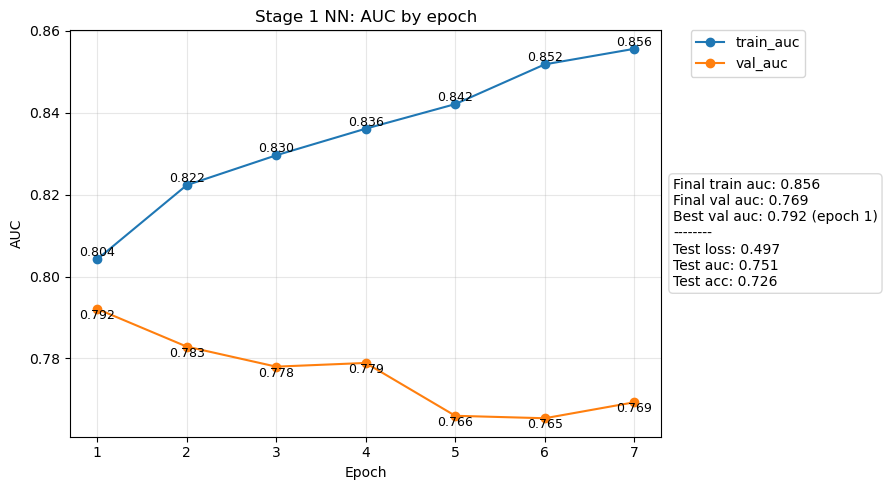

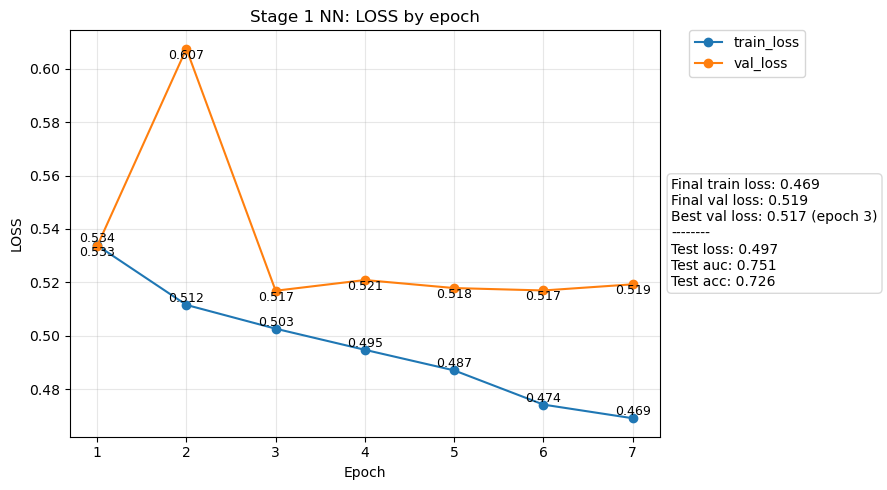

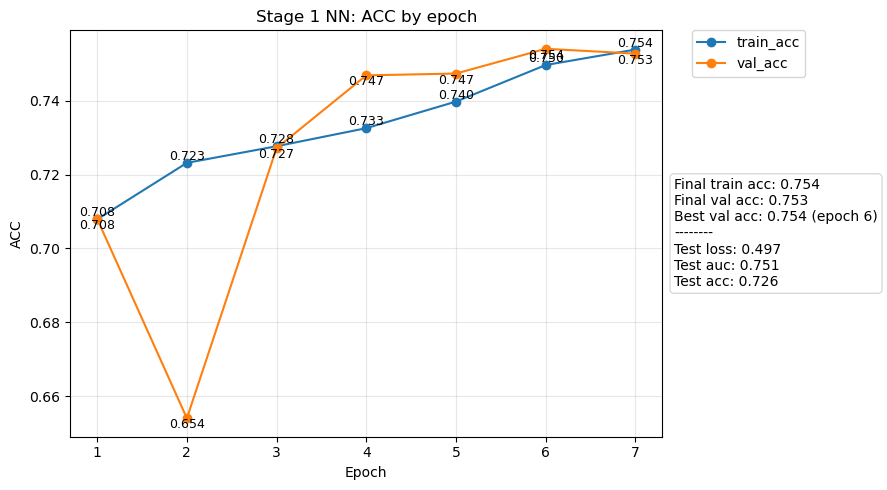

In [95]:
hist_stage1 = pd.DataFrame([
    {"epoch": 1, "acc": 0.7079, "auc": 0.8042, "loss": 0.5339, "val_acc": 0.7080, "val_auc": 0.7921, "val_loss": 0.5335, "lr": 0.0010},
    {"epoch": 2, "acc": 0.7232, "auc": 0.8223, "loss": 0.5116, "val_acc": 0.6540, "val_auc": 0.7829, "val_loss": 0.6074, "lr": 0.0010},
    {"epoch": 3, "acc": 0.7277, "auc": 0.8296, "loss": 0.5027, "val_acc": 0.7272, "val_auc": 0.7780, "val_loss": 0.5169, "lr": 0.0010},
    {"epoch": 4, "acc": 0.7326, "auc": 0.8361, "loss": 0.4948, "val_acc": 0.7469, "val_auc": 0.7789, "val_loss": 0.5209, "lr": 0.0010},
    {"epoch": 5, "acc": 0.7398, "auc": 0.8421, "loss": 0.4871, "val_acc": 0.7474, "val_auc": 0.7660, "val_loss": 0.5179, "lr": 0.0010},
    {"epoch": 6, "acc": 0.7497, "auc": 0.8518, "loss": 0.4743, "val_acc": 0.7541, "val_auc": 0.7654, "val_loss": 0.5170, "lr": 0.0005},
    {"epoch": 7, "acc": 0.7539, "auc": 0.8556, "loss": 0.4692, "val_acc": 0.7528, "val_auc": 0.7693, "val_loss": 0.5193, "lr": 0.0005},
])
test_stage1 = {"loss": 0.4971529, "auc": 0.7510616, "acc": 0.7260011}
plot_metric_labels_and_summary(hist_stage1, "auc",  "Stage 1 NN", test_metrics=test_stage1)
plot_metric_labels_and_summary(hist_stage1, "loss", "Stage 1 NN", test_metrics=test_stage1)
plot_metric_labels_and_summary(hist_stage1, "acc",  "Stage 1 NN", test_metrics=test_stage1)

In [ ]:
# renaming Stage 1 DataFrame for clarity
hist_stage1 = hist.copy()

test_stage1 = {"loss": 0.4971529, "auc": 0.7510616, "acc": 0.7260011}

plot_metric_labels_and_summary(hist_stage1, "auc",  "Stage 1 NN", test_metrics=test_stage1)
plot_metric_labels_and_summary(hist_stage1, "loss", "Stage 1 NN", test_metrics=test_stage1)
plot_metric_labels_and_summary(hist_stage1, "acc",  "Stage 1 NN", test_metrics=test_stage1)


In [70]:
print(trade_model)

<Functional name=functional, built=True>


### <a id="2.3.2"></a>2.3.2 Neural Network - Stage 2 (Trade Direction Prediction)

In [62]:
def make_direction_dataset(X: np.ndarray, y_raw: np.ndarray, lookback: int, batch_size: int, shuffle: bool):
    if len(X) < lookback:
        raise ValueError("Not enough rows for lookback.")

    X_windows = np.lib.stride_tricks.sliding_window_view(X, window_shape=(lookback, X.shape[1]))
    X_windows = X_windows.squeeze(1)  # (n_windows, lookback, n_features)

    y_end = y_raw[lookback - 1:]  # end label
    keep = (y_end != 0)
    Xk = X_windows[keep]
    yk = y_end[keep]
    y_dir = (yk == 1).astype(np.int8)

    ds = tf.data.Dataset.from_tensor_slices((Xk.astype(np.float32), y_dir.astype(np.int8)))
    if shuffle:
        ds = ds.shuffle(min(len(Xk), 20000), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds, y_dir

ds_dir_train, y_dir_train_seq = make_direction_dataset(X_train_imp, y_train, LOOKBACK, BATCH_SIZE, shuffle=True)
ds_dir_val,   y_dir_val_seq   = make_direction_dataset(X_val_imp,   y_val,   LOOKBACK, BATCH_SIZE, shuffle=False)
ds_dir_test,  y_dir_test_seq  = make_direction_dataset(X_test_imp,  y_test,  LOOKBACK, BATCH_SIZE, shuffle=False)

print("Stage 2 trade windows:", {"train": len(y_dir_train_seq), "val": len(y_dir_val_seq), "test": len(y_dir_test_seq)})
print("Stage 2 class balance (train):", np.bincount(y_dir_train_seq, minlength=2) / max(len(y_dir_train_seq), 1))

d0 = np.sum(y_dir_train_seq == 0)
d1 = np.sum(y_dir_train_seq == 1)
dw0 = (d0 + d1) / (2.0 * max(d0, 1))
dw1 = (d0 + d1) / (2.0 * max(d1, 1))
dir_class_weight = {0: float(dw0), 1: float(dw1)}
print("Stage 2 class weights:", dir_class_weight)

def make_direction_model():
    inp = tf.keras.Input(shape=(LOOKBACK, n_features))
    x = norm(inp)
    x = tf.keras.layers.GRU(64, return_sequences=True)(x)
    x = tf.keras.layers.GRU(64)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    out = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=[tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.BinaryAccuracy(name="acc")]
    )
    return model

dir_model = make_direction_model()
dir_model.summary()

dir_model.fit(
    ds_dir_train,
    validation_data=ds_dir_val,
    epochs=EPOCHS,
    class_weight=dir_class_weight,
    callbacks=cb,
    verbose=1
)

print("Stage 2 NN test:")
dir_model.evaluate(ds_dir_test, verbose=1)

Stage 2 trade windows: {'train': 165176, 'val': 35492, 'test': 34809}
Stage 2 class balance (train): [0.49242021 0.50757979]
Stage 2 class weights: {0: 1.015392937936461, 1: 0.9850667938931298}


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 88)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 64, 88)              │             177 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64, 64)              │          29,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,154 (246.70 KB)

 Trainable params: 62,977 (246.00 KB)

 Non-trainable params: 177 (712.00 B)

Epoch 1/25
646/646 ━━━━━━━━━━━━━━━━━━━━ 291s 421ms/step - acc: 0.5376 - auc: 0.5534 - loss: 0.6894 - val_acc: 0.4996 - val_auc: 0.5099 - val_loss: 0.6982 - learning_rate: 0.0010
Epoch 2/25
646/646 ━━━━━━━━━━━━━━━━━━━━ 278s 431ms/step - acc: 0.5664 - auc: 0.5978 - loss: 0.6758 - val_acc: 0.5056 - val_auc: 0.5104 - val_loss: 0.7387 - learning_rate: 0.0010
Epoch 3/25
646/646 ━━━━━━━━━━━━━━━━━━━━ 276s 426ms/step - acc: 0.6079 - auc: 0.6611 - loss: 0.6464 - val_acc: 0.5100 - val_auc: 0.5204 - val_loss: 0.8119 - learning_rate: 5.0000e-04
Epoch 4/25
646/646 ━━━━━━━━━━━━━━━━━━━━ 306s 401ms/step - acc: 0.6468 - auc: 0.7152 - loss: 0.6112 - val_acc: 0.5137 - val_auc: 0.5247 - val_loss: 0.9021 - learning_rate: 5.0000e-04
Stage 2 NN test:
136/136 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - acc: 0.5098 - auc: 0.5032 - loss: 0.7011


[0.7010505199432373, 0.5031840205192566, 0.5097819566726685]

#### Stage 2 Performance Chart

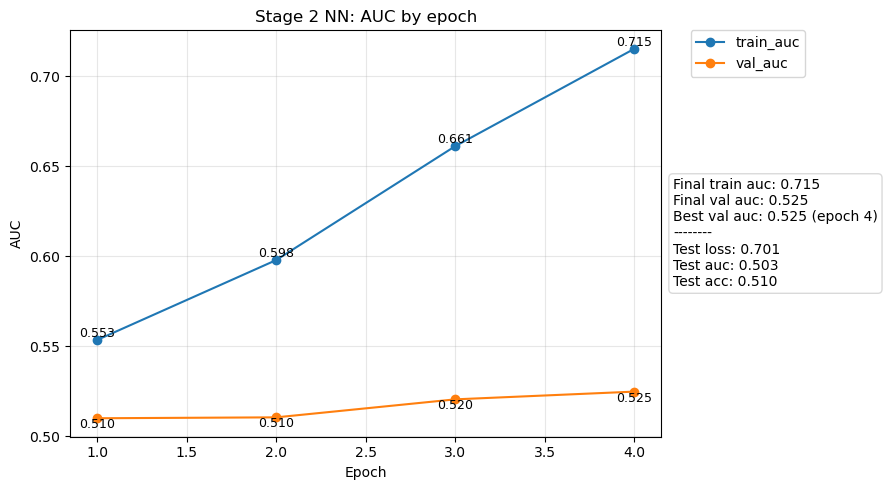

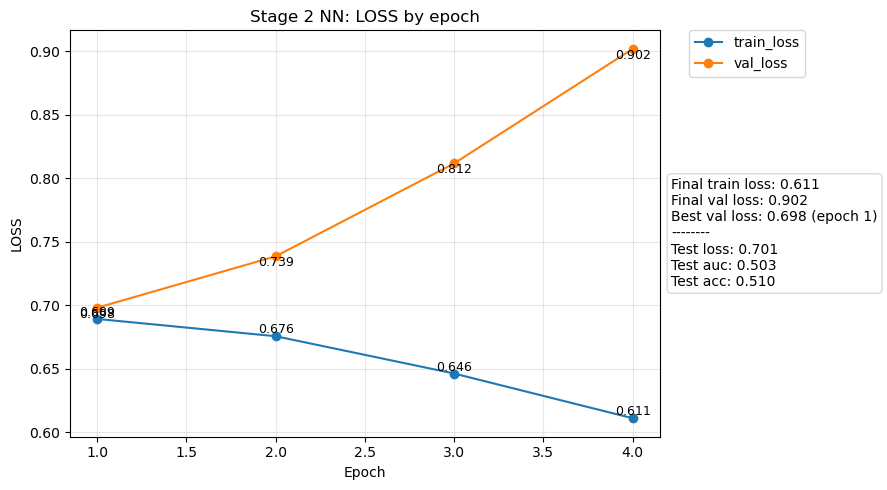

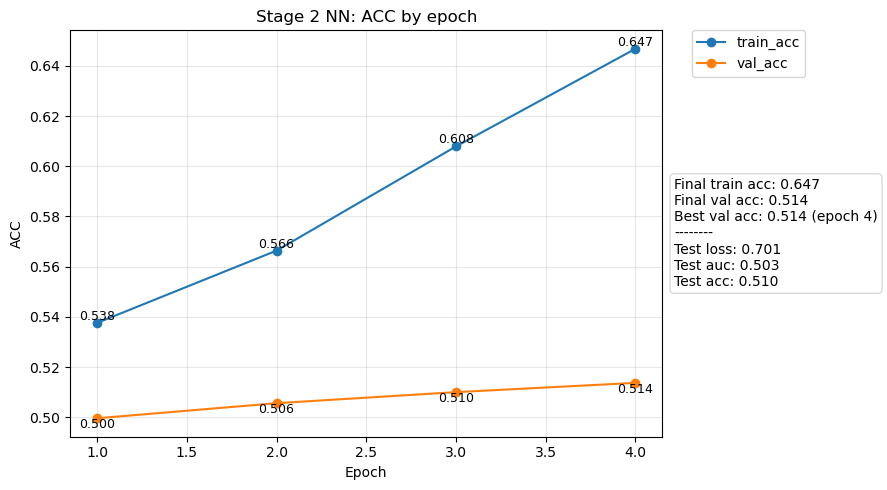

In [96]:
hist_stage2 = pd.DataFrame([
    {"epoch": 1, "acc": 0.5376, "auc": 0.5534, "loss": 0.6894, "val_acc": 0.4996, "val_auc": 0.5099, "val_loss": 0.6982, "lr": 0.0010},
    {"epoch": 2, "acc": 0.5664, "auc": 0.5978, "loss": 0.6758, "val_acc": 0.5056, "val_auc": 0.5104, "val_loss": 0.7387, "lr": 0.0010},
    {"epoch": 3, "acc": 0.6079, "auc": 0.6611, "loss": 0.6464, "val_acc": 0.5100, "val_auc": 0.5204, "val_loss": 0.8119, "lr": 0.0005},
    {"epoch": 4, "acc": 0.6468, "auc": 0.7152, "loss": 0.6112, "val_acc": 0.5137, "val_auc": 0.5247, "val_loss": 0.9021, "lr": 0.0005},
])

test_stage2 = {"loss": 0.7010505, "auc": 0.5031840, "acc": 0.5097820}
plot_metric_labels_and_summary(hist_stage2, "auc",  "Stage 2 NN", test_metrics=test_stage2)
plot_metric_labels_and_summary(hist_stage2, "loss", "Stage 2 NN", test_metrics=test_stage2)
plot_metric_labels_and_summary(hist_stage2, "acc",  "Stage 2 NN", test_metrics=test_stage2)

## <a id="2.4"></a>2.4 Leakage checks

### <a id="2.4.1"></a> 2.4.1 Leakage checksLabel Shuffle

In [63]:
# Helpers
def collect_probs(ds, model):
    ys, ps = [], []
    for xb, yb in ds:
        p = model.predict(xb, verbose=0).reshape(-1)
        ps.append(p)
        ys.append(yb.numpy().reshape(-1))
    return np.concatenate(ys), np.concatenate(ps)

# 5.1 Label shuffle test (Stage 1 NN)
y_shuf = y_train_trade.copy()
rng = np.random.default_rng(SEED)
rng.shuffle(y_shuf)

ds_trade_train_shuf = make_endlabel_dataset(X_train_imp, y_shuf, LOOKBACK, BATCH_SIZE, shuffle=True)

shuf_model = make_trade_filter_model()
shuf_model.fit(ds_trade_train_shuf, validation_data=ds_trade_val, epochs=5, verbose=0)

y1s, p1s = collect_probs(ds_trade_test, shuf_model)
print("Label shuffle Stage 1 NN test AUC (should be ~0.5):", roc_auc_score(y1s, p1s))


Label shuffle Stage 1 NN test AUC (should be ~0.5): 0.44784400577313394


### <a id="2.4.2"></a> 2.4.2 Shifting Features Forward

In [64]:
# 5.2 Time shift test (Stage 2 NN direction)
# Shift features forward by k bars (illegal), AUC should rise.
def shift_features_forward(X: np.ndarray, k: int) -> np.ndarray:
    Xs = np.empty_like(X)
    Xs[:] = np.nan
    if k == 0:
        return X.copy()
    Xs[:-k] = X[k:]
    return Xs

def stage2_auc_with_shift(k: int) -> float:
    Xs = shift_features_forward(X_test_imp, k)
    ok = np.isfinite(Xs).all(axis=1)
    Xs = Xs[ok]
    ys = y_test[ok]

    ds, _ = make_direction_dataset(Xs, ys, LOOKBACK, BATCH_SIZE, shuffle=False)
    y2, p2 = collect_probs(ds, dir_model)
    return roc_auc_score(y2, p2)

for k in [0, 1, 2, 4]:
    try:
        auc = stage2_auc_with_shift(k)
        print(f"Shift {k} bars forward, Stage 2 NN test AUC:", auc)
    except Exception as e:
        print(f"Shift {k} bars failed:", e)


Shift 0 bars forward, Stage 2 NN test AUC: 0.5031472109429364
Shift 1 bars forward, Stage 2 NN test AUC: 0.5019166585606177
Shift 2 bars forward, Stage 2 NN test AUC: 0.5054567052995284
Shift 4 bars forward, Stage 2 NN test AUC: 0.5223940338889457


### <a id="2.4.3"></a> 2.4.3 Single-Feature Scan

In [65]:
# 5.3 Single-feature scan (Stage 1) for suspicious proxy features
y_train_bin = y_train_trade.astype(int)
y_test_bin  = y_test_trade.astype(int)

suspicious = []
for j, col in enumerate(FEATURE_COLS):
    Xtr = X_train_imp[:, [j]]
    Xte = X_test_imp[:,  [j]]

    sc = StandardScaler()
    Xtr_s = sc.fit_transform(Xtr)
    Xte_s = sc.transform(Xte)

    clf = LogisticRegression(max_iter=200, solver="lbfgs")
    clf.fit(Xtr_s, y_train_bin)
    p = clf.predict_proba(Xte_s)[:, 1]
    auc = roc_auc_score(y_test_bin, p)
    if auc >= 0.65:
        suspicious.append((col, auc))

suspicious = sorted(suspicious, key=lambda x: -x[1])
print("Suspicious single-feature AUC >= 0.65 (Stage 1):")
print(suspicious[:25])


Suspicious single-feature AUC >= 0.65 (Stage 1):
[('hour_sin', 0.7242068597931653), ('ATR_ratio_1H_4H', 0.6729290089207685), ('volatility', 0.6634978885454793), ('ATR', 0.6615875647078149)]


In [66]:
import winsound
winsound.PlaySound("SystemExit", winsound.SND_ALIAS)